#Import Libraries

In [ ]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img,img_to_array
import tensorflow as tf
from keras import Sequential, layers, models
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing import image
from keras.models import save_model, load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.regularizers import l2
_random_state = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Visualization

In [ ]:

def hist_image(pos_path, ne_path):
  fire_images = 0
  for filename in os.listdir(pos_path):
      fire_images = fire_images + 1

  nonfire_images = 0
  for filename in os.listdir(ne_path):
      nonfire_images = nonfire_images + 1


  # creating the dataset
  data = {"fire":fire_images, 
          "non-fire":nonfire_images}
  categories = list(data.keys())
  values = list(data.values())

  print("No. of fire images:", fire_images)
  print("No. of non-fire images:", nonfire_images)
  plt.figure(figsize=(5, 5))
  # creating the bar plot
  clrs = ['blue' if (x == "non-fire") else 'red' for x in categories]
  plt.bar(categories, values, color=clrs)

  plt.xlabel("Classes")
  plt.ylabel("No. of images")
  plt.title("Count of images")
  plt.show()

Train set
No. of fire images: 2114
No. of non-fire images: 1931


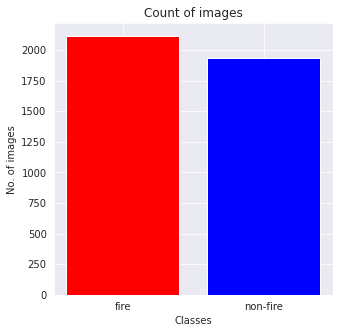

In [ ]:
pos_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Train/fire'
ne_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Train/non-fire'
print("Train set")
hist_image(pos_path, ne_path)

Test set
No. of fire images: 392
No. of non-fire images: 292


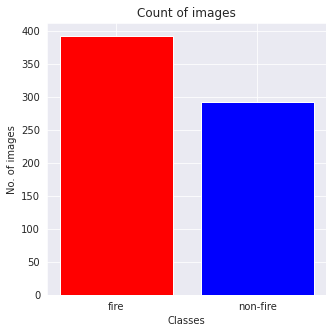

In [ ]:
pos_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Test/fire'
ne_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Test/non-fire'
print("Test set")
hist_image(pos_path, ne_path)

Valid set
No. of fire images: 730
No. of non-fire images: 580


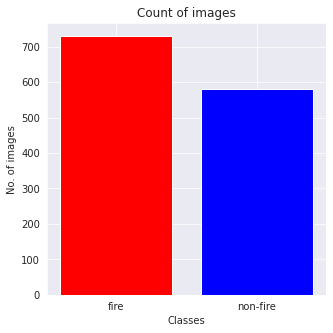

In [ ]:
pos_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Valid/fire'
ne_path = '/content/drive/MyDrive/Major Project/labelImg/SVM/Valid/non-fire'
print("Valid set")
hist_image(pos_path, ne_path)

In [ ]:
labels = ['fire', 'non-fire']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# Now we can easily fetch our train and validation data.
train = get_data('/content/drive/MyDrive/Major Project/labelImg/SVM/Train')
val = get_data('/content/drive/MyDrive/Major Project/labelImg/SVM/Valid')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


time: 369 µs (started: 2022-11-12 21:46:57 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


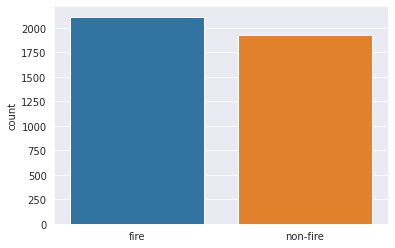

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("fire")
    else:
        l.append("non-fire")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'fire')

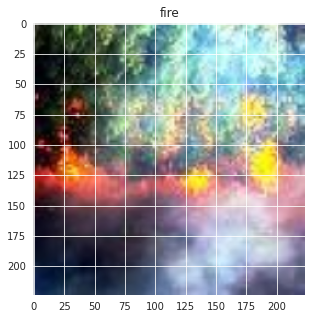

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'non-fire')

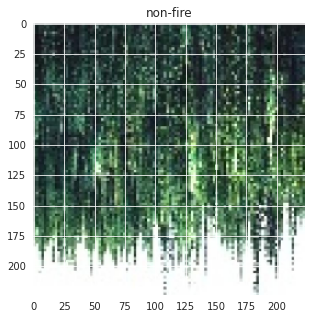

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Data Pre-processing

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

time: 2.48 s (started: 2022-11-12 21:47:05 +00:00)


In [ ]:
# train_datagen = ImageDataGenerator(rescale = 1./255,)
# training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Major Project/labelImg/SVM/Train',
#                                                 target_size = (100, 100),
#                                                  batch_size = 16,
#                                                  class_mode = 'binary')

# test_datagen = ImageDataGenerator(rescale = 1./255)
# test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Major Project/labelImg/SVM/Test',
#                                             target_size = (100, 100),
#                                             batch_size = 16,
#                                             class_mode = 'binary')

In [ ]:
# training_set

#Model Building

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, padding = "same",activation = "relu",kernel_size=3, 
                 strides = 2, input_shape=[224,224,3]))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 8, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16,activation="relu"))

model.add(Dense(1, kernel_regularizer=l2(0.01),activation = "linear"))

# for binary classification using svm activation = linear

time: 2.69 s (started: 2022-11-12 21:47:10 +00:00)


In [ ]:
model.compile(optimizer = 'adam', loss = "hinge", metrics = ['accuracy'])

time: 18.7 ms (started: 2022-11-12 21:47:14 +00:00)


In [ ]:
custom_early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=40,
    restore_best_weights=True
)

time: 965 µs (started: 2022-11-12 21:47:16 +00:00)


In [ ]:
history =  model.fit(x_train, y_train, epochs=250, batch_size=16,
                     callbacks=[custom_early_stopping],
                      verbose=1,
                      validation_data =(x_val, y_val))

Epoch 1/250
253/253 [==============================] - 13s 15ms/step - loss: 0.4582 - accuracy: 0.8020 - val_loss: 0.4400 - val_accuracy: 0.8412
Epoch 2/250
253/253 [==============================] - 4s 16ms/step - loss: 0.2605 - accuracy: 0.8900 - val_loss: 0.3479 - val_accuracy: 0.8519
Epoch 3/250
253/253 [==============================] - 3s 12ms/step - loss: 0.1600 - accuracy: 0.9313 - val_loss: 0.3565 - val_accuracy: 0.8763
Epoch 4/250
253/253 [==============================] - 3s 10ms/step - loss: 0.1272 - accuracy: 0.9473 - val_loss: 0.2859 - val_accuracy: 0.8725
Epoch 5/250
253/253 [==============================] - 3s 11ms/step - loss: 0.1117 - accuracy: 0.9506 - val_loss: 0.2911 - val_accuracy: 0.8802
Epoch 6/250
253/253 [==============================] - 3s 11ms/step - loss: 0.1065 - accuracy: 0.9540 - val_loss: 0.2757 - val_accuracy: 0.8809
Epoch 7/250
253/253 [==============================] - 3s 11ms/step - loss: 0.1010 - accuracy: 0.9565 - val_loss: 0.3198 - val_accuracy

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

# Evaluate model

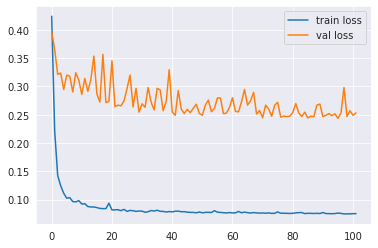

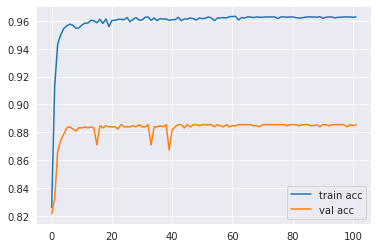

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
predictions = model.predict(x_val)
predictions = predictions.reshape(1,-1)[0]
predictions = [1 if i>0 else 0 for i in predictions]
print(classification_report(y_val, predictions, target_names = ['fire (Class 0)','non-fire (Class 1)']))

41/41 [==============================] - 0s 10ms/step
                    precision    recall  f1-score   support

    fire (Class 0)       1.00      0.79      0.89       730
non-fire (Class 1)       0.79      1.00      0.89       580

          accuracy                           0.89      1310
         macro avg       0.90      0.90      0.89      1310
      weighted avg       0.91      0.89      0.89      1310



In [ ]:
cm = confusion_matrix(y_val.tolist(), predictions)
cm

array([[580, 150],
       [  0, 580]])

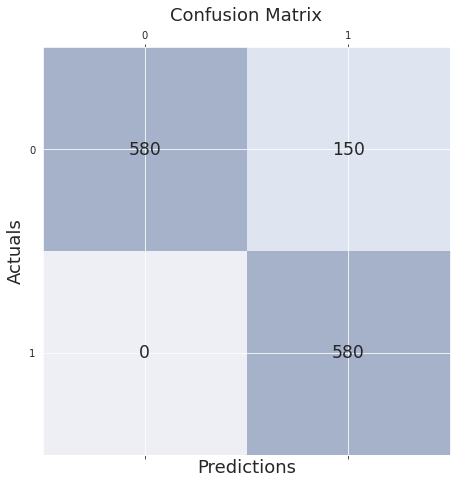

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Test model

In [ ]:
def model_test(img):
  test_image = load_img(img, target_size=(224,224))
  plt.imshow(test_image)
  test_image = img_to_array(test_image)
  test_image=test_image/255
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  print(result)
  if result[0]>0:
      return print("The image classified as non-fire")
  else:
      return print("The image classified as fire")

1/1 [==============================] - 0s 16ms/step
[[1.4850662]]
The image classified as non-fire


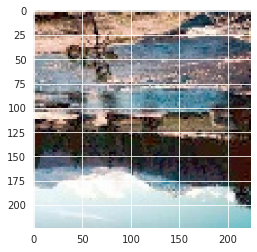

In [ ]:
img = '/content/drive/MyDrive/Major Project/labelImg/SVM/Test/non-fire/1003_jpg.rf.6a5f6f684aea299faf85854125db29c7.jpg'
model_test(img)

1/1 [==============================] - 0s 16ms/step
[[-4.326848]]
The image classified as fire


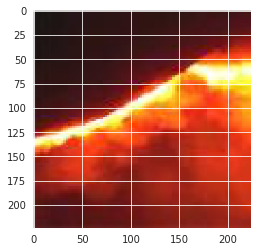

In [ ]:
model_test('/content/drive/MyDrive/Major Project/labelImg/SVM/Test/fire/2216_jpg.rf.9006df83ad6ad8b993c20f36670d7685.jpg')

# Save  model

In [ ]:
model.save_weights('/content/drive/MyDrive/Major Project/codes/Models/SVM/saved_model/svm_final')
model.save('/content/drive/MyDrive/Major Project/codes/Models/SVM/saved_model/svm_final.h5')